# Path planning

## Point to point path planning

The goal is to implement the following equations to determine the values of the coefficients that form a cubic polynomial that represents the position of a robot joint at time $t$.

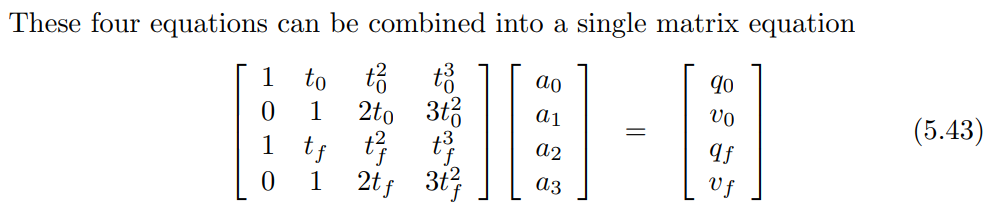

The polynomial is:
$q(t) = a_0 + a_1t + a_2t^2 + a_3t^3$

In [4]:
import numpy as np
q0 = float(input('Enter the initial position q0: '))
qf = float(input('Enter the final position qf: '))
v0 = float(input('Enter the initial velocity v0: '))
vf = float(input('Enter the final velocity vf: '))
t0 = float(input('Enter the initial time t0: '))
tf = float(input('Enter the final time tf: '))

In [6]:
t = np.linspace(t0, tf, int(100 * (tf - t0))) #generate 100 points per second of time.
M = np.array(
[
    [1, t0, t0**2, t0**3],
    [0, 1, 2*t0, 3*t0**2],
    [1, tf, tf**2, tf**3],
    [0, 1, 2*tf, 3*tf**2]
], 
dtype = np.float64)

b = np.array([[q0], [v0], [qf], [vf]], dtype = np.float64)

a = np.linalg.inv(M) @ b

In [7]:
a

array([[ 10.],
       [  0.],
       [-90.],
       [ 60.]])

In [14]:
position = a[0, 0] + a[1, 0]*t + a[2, 0]*t**2 + a[3, 0]*t**3
velocity = a[1, 0] + 2*a[2, 0]*t + 3*a[3, 0]*t**2
acceleration = 2*a[2, 0] + 6*a[3, 0]*t

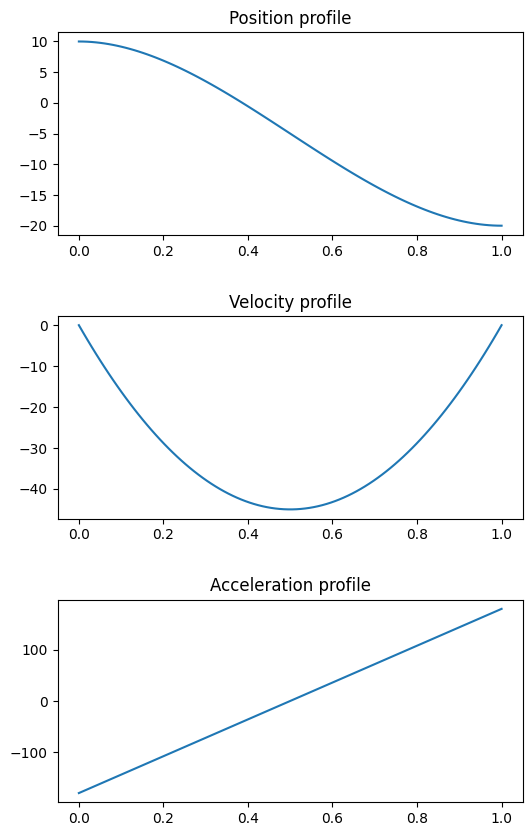

In [20]:
from matplotlib import pyplot as plt

plt.figure(figsize = (6, 10))
plt.subplots_adjust(hspace = 0.4)
plt.subplot(3, 1, 1)
plt.title('Position profile')
plt.plot(t, position)

plt.subplot(3, 1, 2)
plt.title('Velocity profile')
plt.plot(t, velocity)

plt.subplot(3, 1, 3)
plt.title('Acceleration profile')
plt.plot(t, acceleration)
plt.show()